# Linear Variational Principle

In this notebook, we apply the **linear variational principle** to approximate the bound-state energy levels and wavefunctions of the hydrogen atom. The linear variational method is a powerful and widely used approach in quantum mechanics, where the wavefunction is expressed as a linear combination of a finite set of basis functions. The goal is to find the best approximation to the true wavefunction by minimizing the energy expectation value within this limited subspace.

## Problem Background

The hydrogen atom has an exact ground-state solution given by:

$$
\psi_0(r) \propto e^{-r}
$$

To create a meaningful toy model for variational approximation, we **exclude this exact ground-state form** (corresponding to \( n = 0 \)) from our basis set. This allows us to study how well a restricted, non-optimal basis can approximate the true ground-state wavefunction.

We use a set of radial basis functions of the form:

$$
\phi_n(r) = \mathcal{N}_n \cdot r^n \cdot e^{-r}, \quad n \geq 1
$$

where the normalization constant \( \mathcal{N}_n \) ensures that each basis function is properly normalized over three-dimensional space:

$$
\mathcal{N}_n = \frac{1}{\sqrt{4\pi}} \cdot \frac{1}{\sqrt{2^{-2n-3} \cdot (2 + 2n)!}}
$$

These functions are physically motivated: they vanish at the origin, decay exponentially at large distances, and have the right qualitative features to approximate bound-state behavior.

## What We'll Compute

We compute the following matrix elements:

- **Hamiltonian matrix elements**:  
  $$
  H_{n_1,n_2} = \langle \phi_{n_1} | \hat{H} | \phi_{n_2} \rangle
  $$

- **Overlap matrix elements**:  
  $$
  S_{n_1,n_2} = \langle \phi_{n_1} | \phi_{n_2} \rangle
  $$

where the Hamiltonian is:

$$
\hat{H} = -\frac{1}{2} \nabla^2 - \frac{1}{r}
$$

All integrals are evaluated **numerically using the trapezoid method** over a finely discretized radial grid.

We then solve the **generalized eigenvalue problem**:

$$
H \mathbf{c} = E S \mathbf{c}
$$

to find the best approximation of the ground-state energy and the corresponding wavefunction expressed in terms of the chosen basis.

## Exploring the Effect of Basis Size

The primary goal of this notebook is to explore how the quality of the approximation changes as we vary the number of basis functions \( N \). Increasing \( N \) expands the variational space and typically lowers the estimated energy, bringing it closer to the exact result. We track both the **approximate energy** and the **radial probability distribution** of the resulting wavefunction.

At the **bottom of this notebook**, you’ll find an **interactive slider** that allows you to vary $N$ from 1 to 15. The plot is automatically updated to show the corresponding approximation.

> **Note:** We limit $N \leq 15$ because for larger values, the basis functions become nearly linearly dependent. This leads to a nearly singular matrices, which introduces numerical instability in the diagonalization procedure and results in unreliable results.

This notebook provides a hands-on demonstration of the linear variational principle and shows how even simple basis sets can yield meaningful quantum mechanical approximations.

interactive(children=(IntSlider(value=5, description='Number of basis functions', max=15, min=1), Output()), _…

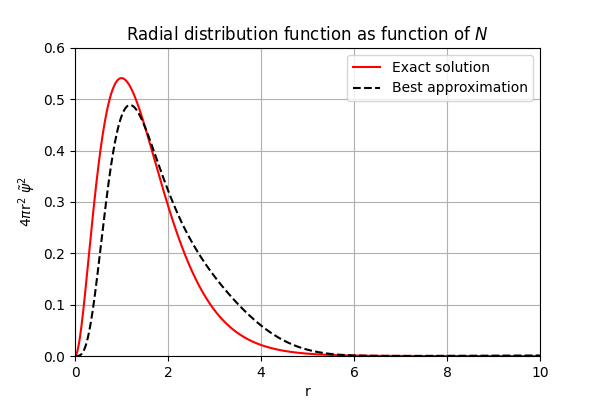

In [1]:
# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import math

# Compatibility wrapper for trapezoidal integration
if hasattr(np, "trapezoid"):
    trapezoid_integrate = np.trapezoid
else:
    trapezoid_integrate = np.trapz

# Ensure interactive plots
%matplotlib widget

def hamiltonian(n1, n2, sz=100, Ns=10000):
    """
    Calculate Hamiltonian element
    """
    d = sz / Ns
    r = np.linspace(0,sz,Ns)
    return 4 * np.pi * trapezoid_integrate(phi(r,n1) * (kinetic_phi(r,n2) + potential_phi(r,n2))) * d
    
def overlap(n1, n2, sz=100, Ns=10000):
    """
    Calculate overlap element
    """
    d = sz / Ns
    r = np.linspace(0,sz,Ns)
    return 4 * np.pi * trapezoid_integrate(r**2 * phi(r,n1) * phi(r,n2)) * 100 / 10000

def N(n):
    """
    Calculate normalization constant
    """
    return 1 / np.sqrt(4 * np.pi) / np.sqrt(2**(-2*n-3) * math.factorial(2+2*n))

def phi(r, n):
    """
    Generate basis function
    """
    return N(n) * np.power(r,n) * np.exp(-r)

def kinetic_phi(r, n):
    """
    Apply kinetic operator to basis function
    The r**2 term required for integration is **included**
    """
    return - 0.5 * (n + n**2 - 2 * n * r + r * (r-2)) * phi(r,n)

def potential_phi(r, n):
    """
    Apply potential operator to basis function
    The r**2 term required for integration is **included**
    """
    return -r * phi(r,n)

# Set up radial domain for plotting the wavefunction
rmax = 10                     # Maximum value of radial coordinate r
Nsamples = 2000              # Number of sample points in the radial grid
r = np.linspace(0, rmax, Nsamples)  # Radial grid

# Create a persistent figure and axis for plotting
fig, ax = plt.subplots(figsize=(6, 4))

# Plot the exact solution (n=0), which is excluded from the basis set
true_func_line, = ax.plot(
    r,
    4 * np.pi * r**2 * phi(r, 0)**2,
    'r-',
    label="Exact solution"
)

# Placeholder for the approximate solution (to be updated interactively)
approx_func_line, = ax.plot(
    r,
    np.zeros_like(r),
    'k--',
    label="Best approximation"
)

# Configure plot appearance
ax.set_xlabel("r")
ax.set_ylabel(r"4$\pi$r$^{2}$ $\tilde{\psi}^{2}$")  # Radial probability density
ax.set_xlim(0, rmax)
ax.set_ylim(0, 0.6)
ax.set_title("Radial distribution function as function of $N$")
ax.legend()
ax.grid(True)

def update_plot(N):
    """
    Updates the approximation plot as the number of basis functions (N) changes.
    Uses the linear variational principle with an N-dimensional basis.
    """
    # Initialize Hamiltonian and overlap matrices
    S = np.zeros((N, N))  # Overlap matrix
    H = np.zeros((N, N))  # Hamiltonian matrix

    # Populate the matrices using numerical integration
    for i in range(1, N + 1):
        for j in range(1, N + 1):
            S[i - 1, j - 1] = overlap(i, j)
            H[i - 1, j - 1] = hamiltonian(i, j)

    # Solve the generalized eigenvalue problem Hc = ESc
    # Step 1: Diagonalize S to get transformation matrix X
    e, v = np.linalg.eigh(S)
    X = v @ np.diag(1 / np.sqrt(e))  # S^{-1/2}

    # Step 2: Transform H into the orthonormal basis
    Hp = X.T @ H @ X

    # Step 3: Solve the eigenproblem in the new basis
    ep, Cp = np.linalg.eigh(Hp)     # Eigenvalues and eigenvectors
    C = X @ Cp                      # Transform eigenvectors back

    # Construct the variational wavefunction using the lowest eigenvector
    s = np.sum([C[i, 0] * phi(r, i + 1) for i in range(N)], axis=0)

    # Update the plot with the radial probability density
    approx_func_line.set_ydata(4 * np.pi * r**2 * s**2)

    # Confirm normalization by integrating electron density over space
    I = trapezoid_integrate(4 * np.pi * r**2 * s**2) * rmax / Nsamples

    # Redraw the figure without flickering
    fig.canvas.draw_idle()

    # Print results
    print(f'The variational energy is: E = {ep[0]:.4f}. Exact = -0.5 Ht')
    print(f'The integrated electron density is: S = {I:.4f}. Exact = 1.0000')

# Disable unnecessary UI elements in the interactive plot display
fig.canvas.toolbar_visible = False  
fig.canvas.header_visible = False  
fig.canvas.footer_visible = False  

# Create an interactive slider to vary the number of basis functions
N_slider = widgets.IntSlider(
    min=1, max=15, step=1, value=5,
    description="Number of basis functions"
)

# Link slider to update function and display interactive UI
widgets.interactive(update_plot, N=N_slider)